# Environment Setup

In [1]:
from google.colab import drive

drive.mount("/gdrive")
%cd /gdrive/My Drive/ANNDL/[2024-2025] AN2DL/Homework 2

Mounted at /gdrive
/gdrive/My Drive/ANNDL/[2024-2025] AN2DL/Homework 2


In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
from scipy.ndimage import distance_transform_edt

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
import keras as tfk
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


2.17.1


In [211]:
# Set batch size for training
BATCH_SIZE = 32

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 20

# Set maximum number of training epochs
EPOCHS = 150

# Set data split size for training and validation
SPLITS_SIZE = 400

# Load data paths

In [4]:
print("Loading file paths...")
image_paths = sorted([os.path.join('data', f) for f in os.listdir('data')])
label_paths = sorted([os.path.join('labels', f) for f in os.listdir('labels')])
print("File paths loaded!")

# Display some examples of paths
print("\nFirst 5 image paths:", image_paths[:5])
print("First 5 label paths:", label_paths[:5])

Loading file paths...
File paths loaded!

First 5 image paths: ['data/image_0.png', 'data/image_1.png', 'data/image_10.png', 'data/image_100.png', 'data/image_1000.png']
First 5 label paths: ['labels/label_0.png', 'labels/label_1.png', 'labels/label_10.png', 'labels/label_100.png', 'labels/label_1000.png']


In [3]:
category_map={
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
}

In [5]:
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(label)

In [6]:
def load_single_image(image_path, label_path, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)  # Ensure single channel
    image = tf.image.resize(image, input_size)   # Resize to fixed size
    image = tf.cast(image, tf.float32)

    # Read and preprocess the label
    label = tf.io.read_file(label_path)
    label = tf.io.decode_png(label, channels=1)  # Ensure single channel
    label = tf.image.resize(label, input_size, method='bilinear')  # Resize to fixed size
    label = tf.cast(label, tf.int32)

    return image, label

# Augmentation and data loading
The augmentations include:

* Horizontal and Vertical Flip: The image and mask are randomly flipped either horizontally or vertically.
* Random Rotation: The image and mask are rotated by 90 degrees with a random factor.
* Random Zoom: The image and mask are randomly zoomed in or out, resizing them to a new scale before returning them to the original size.

In [210]:
def augmenter(image, mask):
    # Randomly flip the image and mask horizontally
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Randomly flip the image and mask vertically
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random rotation
    if tf.random.uniform(()) > 0.5:
        r = int(tf.random.uniform((), minval=0, maxval=1, dtype=tf.int32))
        image = tf.image.rot90(image, k = 2*r)
        mask = tf.image.rot90(mask, k= 2*r)

    # Random zoom
    if tf.random.uniform(()) > 0.5:
        scales = list(np.arange(0.8, 1.0, 0.05))
        scale = random.choice(scales)
        image_shape = tf.shape(image)
        h, w = 64, 128
        new_h = tf.maximum(1, tf.cast(h * scale, tf.int32))
        new_w = tf.maximum(1, tf.cast(w * scale, tf.int32))
        image = tf.image.resize(image, (new_h, new_w))
        mask = tf.image.resize(mask, (new_h, new_w))

        # Resize back to original size
        image = tf.image.resize_with_crop_or_pad(image, h, w)
        mask = tf.image.resize_with_crop_or_pad(mask, h, w)
        mask = tf.cast(mask, tf.int32)
    return image, mask

In [207]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset = dataset.map(
            lambda x, y: augmenter(x,y),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [204]:
train_img, val_img, train_lbl, val_lbl = train_test_split(
    image_paths, label_paths, test_size=SPLITS_SIZE, random_state=seed
)

In [208]:
train_dataset1 = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed,
)
val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Visualizing examples from the training set:


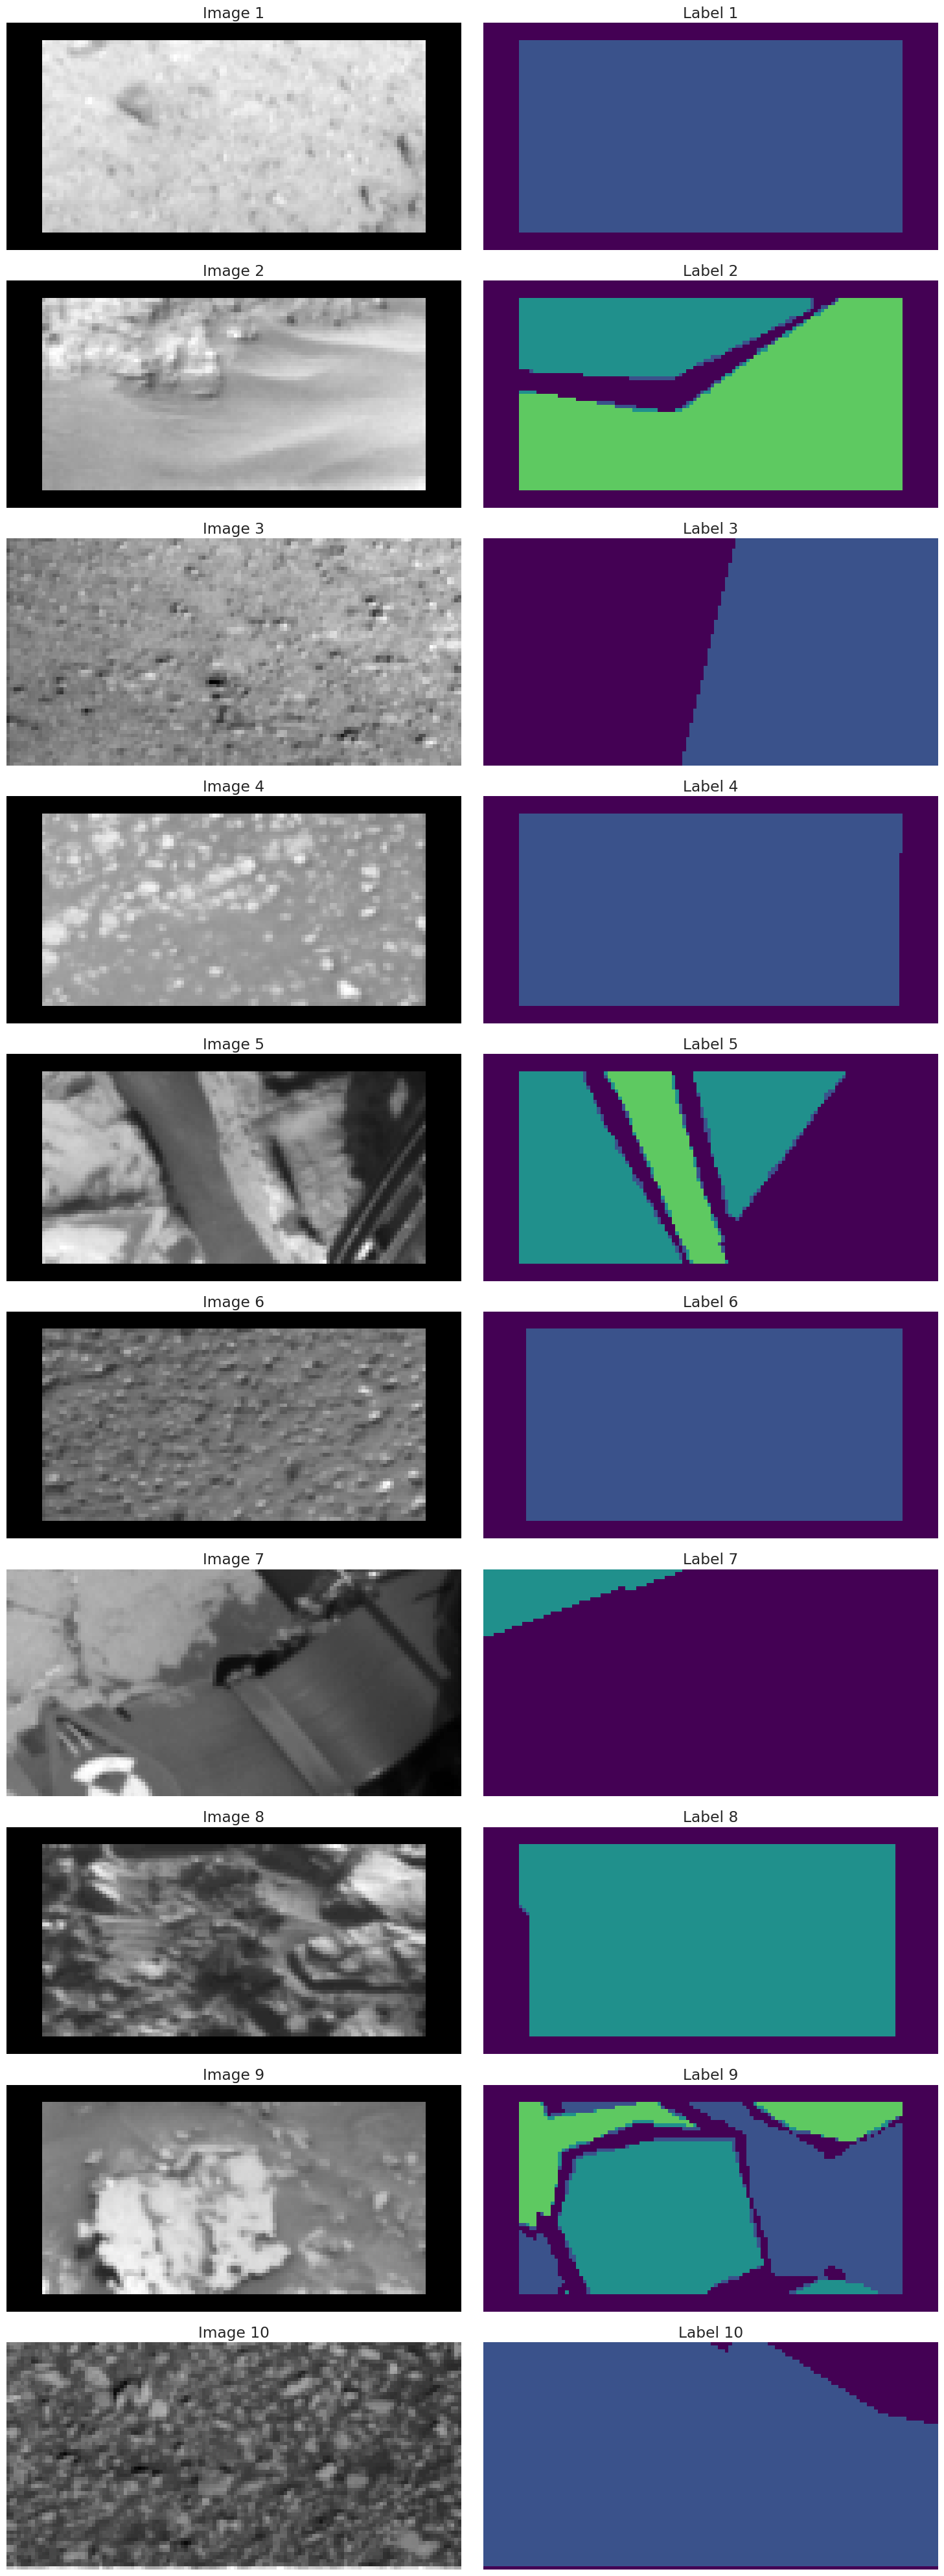

In [209]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j], cmap='gray')
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset1, num_samples=10)

# Model
This U-Net model is designed for image segmentation, enhanced with advanced components like dilated convolutions, a global context module, and a squeeze-and-excitation block. The model consists of:

* Downsampling Path: Series of convolutional blocks followed by max-pooling layers to capture local features.
* Bottleneck: Applies parallel dilated convolutions and a global context module to capture multi-scale and global features.
* Upsampling Path: Uses transpose convolutions and concatenation with corresponding downsampling features to reconstruct the image.
* Output Layer: Produces pixel-wise class predictions.

These enhancements improve feature extraction and representation, making the model suitable for complex segmentation tasks.

In [169]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [170]:
def parallel_dilated_convs(x, name=''):
    dilated1 = tfkl.Conv2D(filters=128, kernel_size=3, dilation_rate=1, padding='same', activation='relu')(x)
    x = tfkl.BatchNormalization(name=name + 'bn1')(x)
    dilated2 = tfkl.Conv2D(filters=128, kernel_size=3, dilation_rate=2, padding='same', activation='relu')(x)
    # x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 2))(x)
    dilated3 = tfkl.Conv2D(filters=128, kernel_size=3, dilation_rate=3, padding='same', activation='relu')(x)
    # x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 3))(x)
    return tfkl.add([dilated1,dilated2,dilated3])

def global_context_module(x, name=''):
    context = tfkl.GlobalAveragePooling2D()(x)
    context = tfkl.Reshape((1, 1, context.shape[-1]))(context)
    context = tfkl.Conv2D(filters=x.shape[-1], kernel_size=1, padding='same', activation='sigmoid')(context)
    x = tfkl.BatchNormalization(name=name + 'bn2')(x)
    return tfkl.Multiply()([x, context])

def se_block(x, reduction=16, name=''):
    channels = x.shape[-1]
    se = tfkl.GlobalAveragePooling2D()(x)
    se = tfkl.Dense(channels // reduction, activation='relu')(se)
    se = tfkl.Dense(channels, activation='sigmoid')(se)
    se = tfkl.Reshape((1, 1, channels))(se)
    return tfkl.Multiply()([x, se])

In [171]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=seed, name=''):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    x = tfkl.BatchNormalization(name='input_normalization')(input_layer)

    # Downsampling path
    down_block_1 = unet_block(x, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)
    d1 = tfkl.BatchNormalization()(d1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)
    d2 = tfkl.BatchNormalization()(d2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')
    bottleneck = tfkl.BatchNormalization()(bottleneck)
    bottleneck = parallel_dilated_convs(bottleneck)
    bottleneck = tfkl.BatchNormalization()(bottleneck)

    bottleneck = global_context_module(bottleneck)
    bottleneck = se_block(bottleneck)

    # Upsampling path
    u1 = tfkl.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(bottleneck)
    u1 = tfkl.BatchNormalization()(u1)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    #u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(u1)
    u2 = tfkl.BatchNormalization()(u2)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ input_normalization    │ (None, 64, 128, 1)   │            4 │ input_layer[0][0]   │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_normalizatio… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d_4        │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ batch_normalization_12 │ (None, 32, 64, 32)   │          128 │ max_pooling2d_4[0]… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ batch_normalizatio… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├──────────────────────

 Total params: 1,011,921 (3.86 MB)

 Trainable params: 1,009,167 (3.85 MB)

 Non-trainable params: 2,754 (10.76 KB)

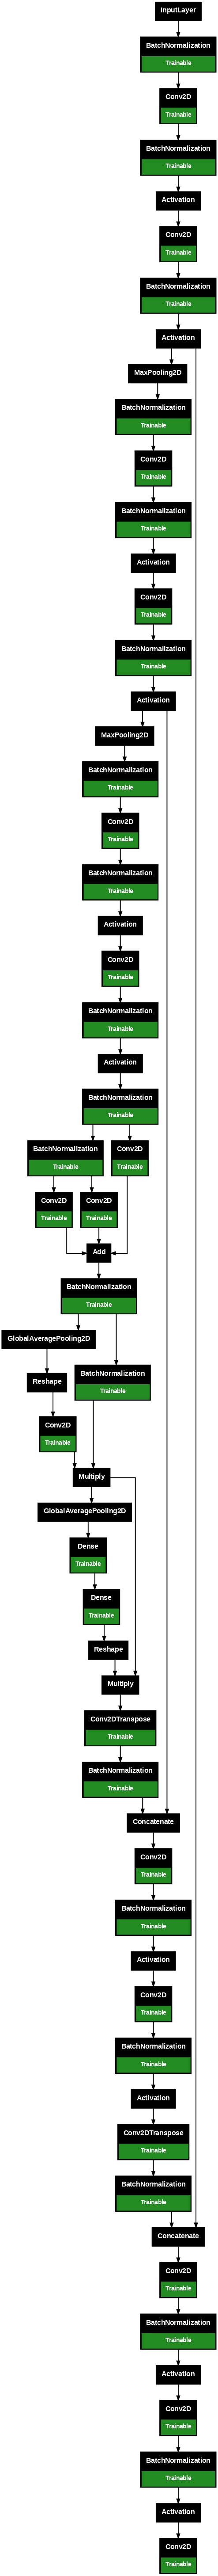

In [213]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

# Model Training
* Custom Metrics: A MeanIntersectionOverUnion metric is defined to compute IoU, excluding specific classes (default is class 0).
* Focal Loss: A custom focal loss is used, applying class weights based on dataset distribution to focus on underrepresented classes.
* Visualization: A callback visualizes input images, ground truth, and predictions every few epochs to monitor progress.
* Model Training: The model is compiled with focal loss, an AdamW optimizer, and custom metrics. Training uses early stopping, and the model is saved with the final accuracy.

In [214]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = 5
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [215]:
@tf.keras.utils.register_keras_serializable(package="Custom")
def focal_loss(y_true, y_pred, class_weight=None, gamma=2., alpha=0.25):
    # Calculate cross-entropy
    cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)

    # If class weights are provided, apply them
    if class_weight is not None:
        y_true = tf.cast(y_true, tf.int32)
        weights = tf.gather(class_weight, y_true)  # Extract weights based on true labels

        weights = tf.squeeze(weights, axis=-1)
        cross_entropy = cross_entropy * weights

    # Calculate the focal loss
    loss = alpha * tf.pow(1 - cross_entropy, gamma)
    return tf.reduce_mean(loss)

These class weights are derived from the percentage of images in the dataset with at least one pixel of the corresponding class.


1.   0.380 -> 2.63
2.   0.345 -> 2.90
3.   0.256 -> 3.91
4.   0.0187 -> 53.48




In [216]:
# Definition of class weights
class_weights = {0: 0, 1: 2.63, 2: 2.90, 3: 3.91, 4: 53.48}

# Compiling the model
print("Compiling model...")
model.compile(
    loss=lambda y_true, y_pred: focal_loss(y_true, y_pred, class_weight=tf.constant(list(class_weights.values()))),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])],
)
print("Model compiled!")

Compiling model...
Model compiled!


In [217]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(val_img[1], val_lbl[1])

Epoch 1/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 9.8513 - mean_iou: 0.0788 - sparse_categorical_crossentropy: 1.7662

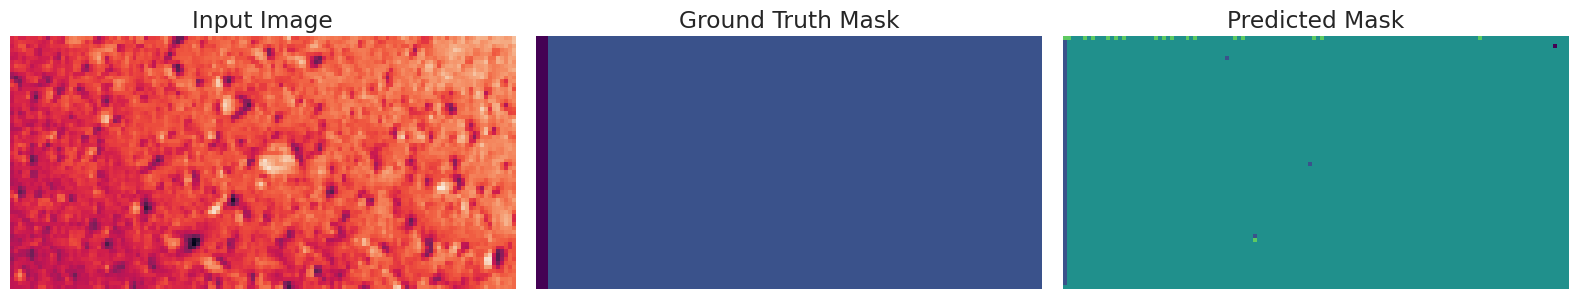

66/66 ━━━━━━━━━━━━━━━━━━━━ 48s 394ms/step - loss: 9.8027 - mean_iou: 0.0790 - sparse_categorical_crossentropy: 1.7654 - val_loss: 3.9612 - val_mean_iou: 0.0982 - val_sparse_categorical_crossentropy: 1.5593
Epoch 2/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 4.6968 - mean_iou: 0.1405 - sparse_categorical_crossentropy: 1.6241 - val_loss: 4.0125 - val_mean_iou: 0.0963 - val_sparse_categorical_crossentropy: 1.5365
Epoch 3/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 3.5541 - mean_iou: 0.1668 - sparse_categorical_crossentropy: 1.6277 - val_loss: 3.8402 - val_mean_iou: 0.0616 - val_sparse_categorical_crossentropy: 1.5349
Epoch 4/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 2.6687 - mean_iou: 0.1731 - sparse_categorical_crossentropy: 1.6122 - val_loss: 3.5557 - val_mean_iou: 0.0659 - val_sparse_categorical_crossentropy: 1.5494
Epoch 5/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 2.6353 - mean_iou: 0.1782 - sparse_categorical_crossentropy: 1.6039 - val_loss: 3.09

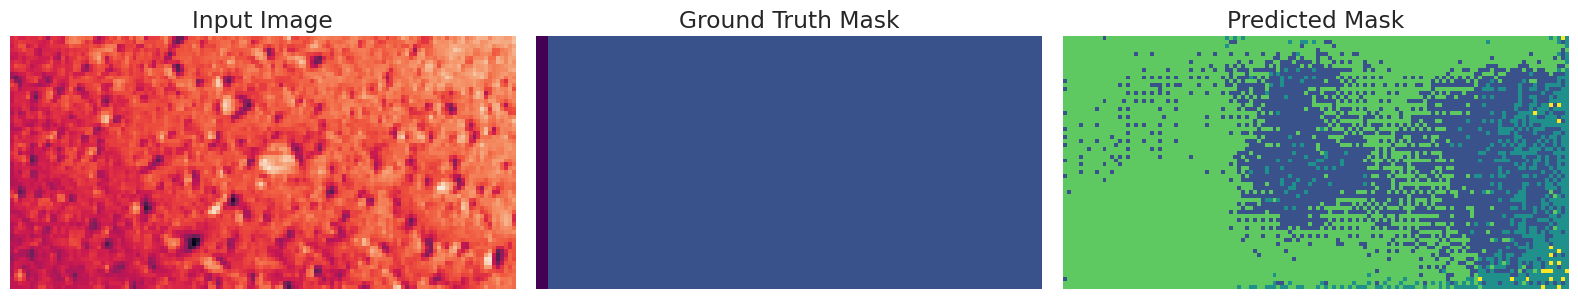

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 2.2290 - mean_iou: 0.1957 - sparse_categorical_crossentropy: 1.5825 - val_loss: 2.5526 - val_mean_iou: 0.1648 - val_sparse_categorical_crossentropy: 1.4982
Epoch 7/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 2.1486 - mean_iou: 0.1947 - sparse_categorical_crossentropy: 1.5749 - val_loss: 2.2833 - val_mean_iou: 0.1644 - val_sparse_categorical_crossentropy: 1.5342
Epoch 8/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 2.0285 - mean_iou: 0.2054 - sparse_categorical_crossentropy: 1.5685 - val_loss: 2.0173 - val_mean_iou: 0.2119 - val_sparse_categorical_crossentropy: 1.5032
Epoch 9/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 1.8421 - mean_iou: 0.2180 - sparse_categorical_crossentropy: 1.5624 - val_loss: 1.7066 - val_mean_iou: 0.2253 - val_sparse_categorical_crossentropy: 1.4844
Epoch 10/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 1.6367 - mean_iou: 0.2282 - sparse_categorical_crossentropy: 1.5535 - val_loss: 1.7

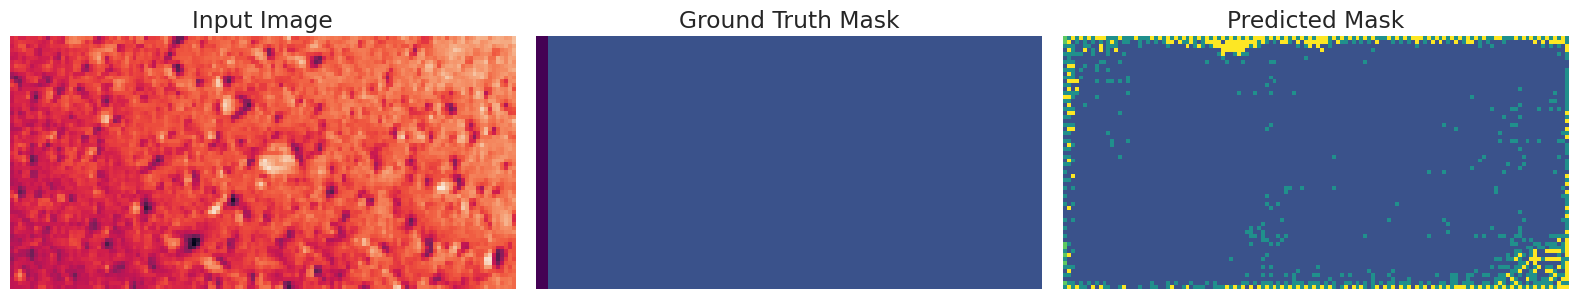

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 2.0190 - mean_iou: 0.2164 - sparse_categorical_crossentropy: 1.5755 - val_loss: 1.6458 - val_mean_iou: 0.2402 - val_sparse_categorical_crossentropy: 1.4844
Epoch 12/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 1.6779 - mean_iou: 0.2332 - sparse_categorical_crossentropy: 1.5537 - val_loss: 1.5217 - val_mean_iou: 0.2626 - val_sparse_categorical_crossentropy: 1.4725
Epoch 13/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 1.6136 - mean_iou: 0.2428 - sparse_categorical_crossentropy: 1.5529 - val_loss: 1.4847 - val_mean_iou: 0.2677 - val_sparse_categorical_crossentropy: 1.4367
Epoch 14/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 1.5767 - mean_iou: 0.2573 - sparse_categorical_crossentropy: 1.5490 - val_loss: 1.3861 - val_mean_iou: 0.2852 - val_sparse_categorical_crossentropy: 1.4235
Epoch 15/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 1.5126 - mean_iou: 0.2699 - sparse_categorical_crossentropy: 1.5372 - val_loss: 1

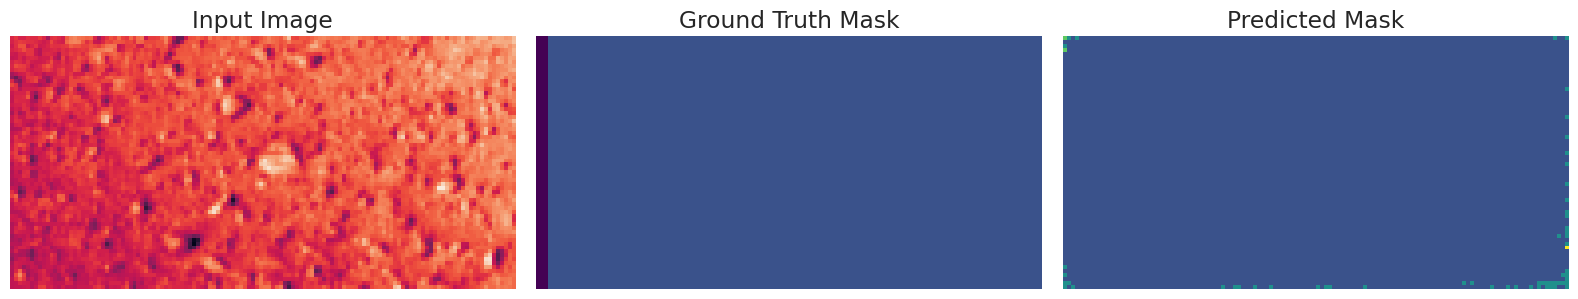

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 1.4538 - mean_iou: 0.2759 - sparse_categorical_crossentropy: 1.5322 - val_loss: 1.6686 - val_mean_iou: 0.2604 - val_sparse_categorical_crossentropy: 1.4820
Epoch 17/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 1.4851 - mean_iou: 0.2791 - sparse_categorical_crossentropy: 1.5538 - val_loss: 1.5856 - val_mean_iou: 0.2488 - val_sparse_categorical_crossentropy: 1.5369
Epoch 18/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 1.6607 - mean_iou: 0.2511 - sparse_categorical_crossentropy: 1.5819 - val_loss: 1.4588 - val_mean_iou: 0.2806 - val_sparse_categorical_crossentropy: 1.4960
Epoch 19/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 1.3988 - mean_iou: 0.2681 - sparse_categorical_crossentropy: 1.5738 - val_loss: 1.2622 - val_mean_iou: 0.3144 - val_sparse_categorical_crossentropy: 1.4426
Epoch 20/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 1.3857 - mean_iou: 0.2859 - sparse_categorical_crossentropy: 1.5474 - val_loss: 

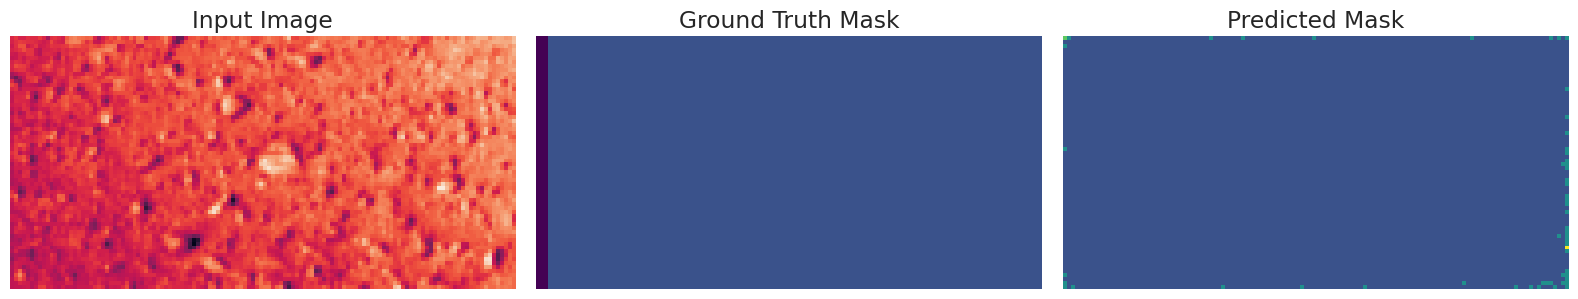

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 1.3313 - mean_iou: 0.2822 - sparse_categorical_crossentropy: 1.5474 - val_loss: 1.1430 - val_mean_iou: 0.3191 - val_sparse_categorical_crossentropy: 1.4297
Epoch 22/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 1.1755 - mean_iou: 0.3002 - sparse_categorical_crossentropy: 1.5655 - val_loss: 1.1315 - val_mean_iou: 0.3274 - val_sparse_categorical_crossentropy: 1.4026
Epoch 23/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 1.1011 - mean_iou: 0.3140 - sparse_categorical_crossentropy: 1.5392 - val_loss: 1.2831 - val_mean_iou: 0.2991 - val_sparse_categorical_crossentropy: 1.5001
Epoch 24/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 1.1523 - mean_iou: 0.3060 - sparse_categorical_crossentropy: 1.5618 - val_loss: 1.1224 - val_mean_iou: 0.3068 - val_sparse_categorical_crossentropy: 1.4754
Epoch 25/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 1.1046 - mean_iou: 0.3155 - sparse_categorical_crossentropy: 1.5447 - val_loss: 1

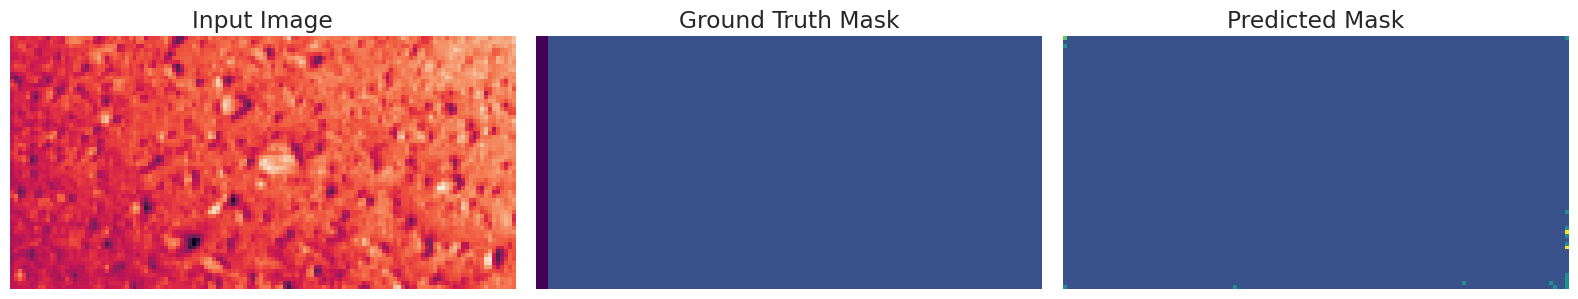

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 1.0809 - mean_iou: 0.3238 - sparse_categorical_crossentropy: 1.5546 - val_loss: 1.1669 - val_mean_iou: 0.3950 - val_sparse_categorical_crossentropy: 1.4294
Epoch 27/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 1.1703 - mean_iou: 0.3186 - sparse_categorical_crossentropy: 1.5641 - val_loss: 1.7313 - val_mean_iou: 0.2852 - val_sparse_categorical_crossentropy: 1.6054
Epoch 28/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 1.1446 - mean_iou: 0.3045 - sparse_categorical_crossentropy: 1.5524 - val_loss: 0.9845 - val_mean_iou: 0.3479 - val_sparse_categorical_crossentropy: 1.4119
Epoch 29/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 1.1041 - mean_iou: 0.3193 - sparse_categorical_crossentropy: 1.5629 - val_loss: 1.0036 - val_mean_iou: 0.3791 - val_sparse_categorical_crossentropy: 1.4063
Epoch 30/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 1.1568 - mean_iou: 0.3297 - sparse_categorical_crossentropy: 1.5824 - val_loss: 0

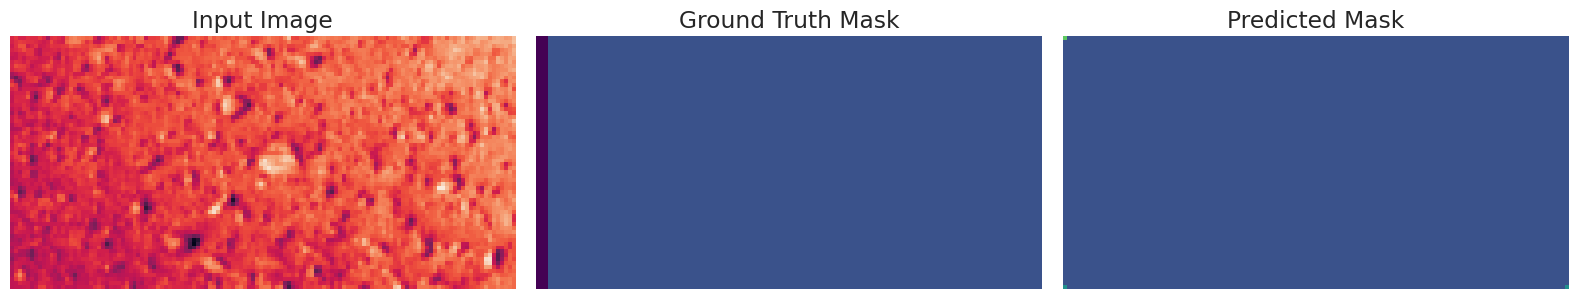

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 1.0516 - mean_iou: 0.3422 - sparse_categorical_crossentropy: 1.5750 - val_loss: 1.4157 - val_mean_iou: 0.2680 - val_sparse_categorical_crossentropy: 1.5462
Epoch 32/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 1.0691 - mean_iou: 0.3237 - sparse_categorical_crossentropy: 1.5910 - val_loss: 0.8997 - val_mean_iou: 0.3794 - val_sparse_categorical_crossentropy: 1.3910
Epoch 33/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.9240 - mean_iou: 0.3434 - sparse_categorical_crossentropy: 1.5580 - val_loss: 0.9906 - val_mean_iou: 0.3479 - val_sparse_categorical_crossentropy: 1.4325
Epoch 34/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.9980 - mean_iou: 0.3377 - sparse_categorical_crossentropy: 1.5864 - val_loss: 0.8898 - val_mean_iou: 0.3791 - val_sparse_categorical_crossentropy: 1.4173
Epoch 35/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.9584 - mean_iou: 0.3480 - sparse_categorical_crossentropy: 1.5857 - val_loss: 0.

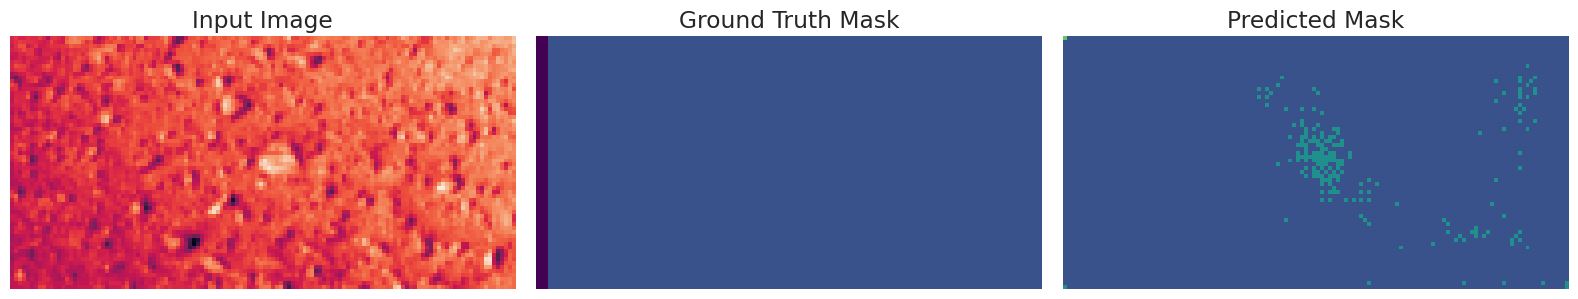

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.8792 - mean_iou: 0.3538 - sparse_categorical_crossentropy: 1.5869 - val_loss: 1.1325 - val_mean_iou: 0.3559 - val_sparse_categorical_crossentropy: 1.4730
Epoch 37/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 1.0516 - mean_iou: 0.3389 - sparse_categorical_crossentropy: 1.5894 - val_loss: 2.9794 - val_mean_iou: 0.2078 - val_sparse_categorical_crossentropy: 1.6007
Epoch 38/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 1.7290 - mean_iou: 0.2524 - sparse_categorical_crossentropy: 1.6727 - val_loss: 3.5808 - val_mean_iou: 0.2150 - val_sparse_categorical_crossentropy: 1.7543
Epoch 39/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 2.2624 - mean_iou: 0.2213 - sparse_categorical_crossentropy: 1.7196 - val_loss: 1.3194 - val_mean_iou: 0.2989 - val_sparse_categorical_crossentropy: 1.4993
Epoch 40/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 1.2463 - mean_iou: 0.2715 - sparse_categorical_crossentropy: 1.6749 - val_loss: 1

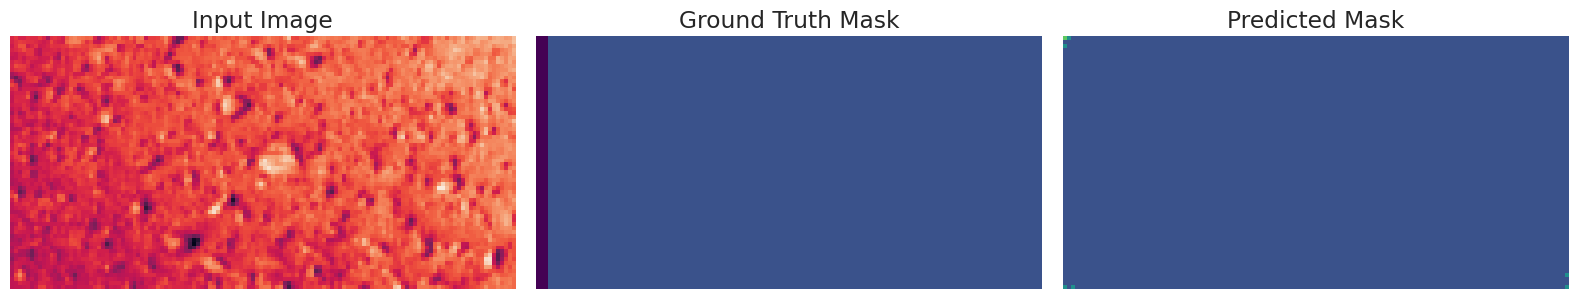

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 1.1121 - mean_iou: 0.3093 - sparse_categorical_crossentropy: 1.6460 - val_loss: 1.0190 - val_mean_iou: 0.4161 - val_sparse_categorical_crossentropy: 1.5169
Epoch 42/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.9670 - mean_iou: 0.3302 - sparse_categorical_crossentropy: 1.6592 - val_loss: 1.0105 - val_mean_iou: 0.4417 - val_sparse_categorical_crossentropy: 1.5095
Epoch 43/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.8905 - mean_iou: 0.3546 - sparse_categorical_crossentropy: 1.6316 - val_loss: 1.0184 - val_mean_iou: 0.4308 - val_sparse_categorical_crossentropy: 1.5344
Epoch 44/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.9348 - mean_iou: 0.4347 - sparse_categorical_crossentropy: 1.6595 - val_loss: 0.9237 - val_mean_iou: 0.4669 - val_sparse_categorical_crossentropy: 1.5309
Epoch 45/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.8726 - mean_iou: 0.3590 - sparse_categorical_crossentropy: 1.6388 - val_loss:

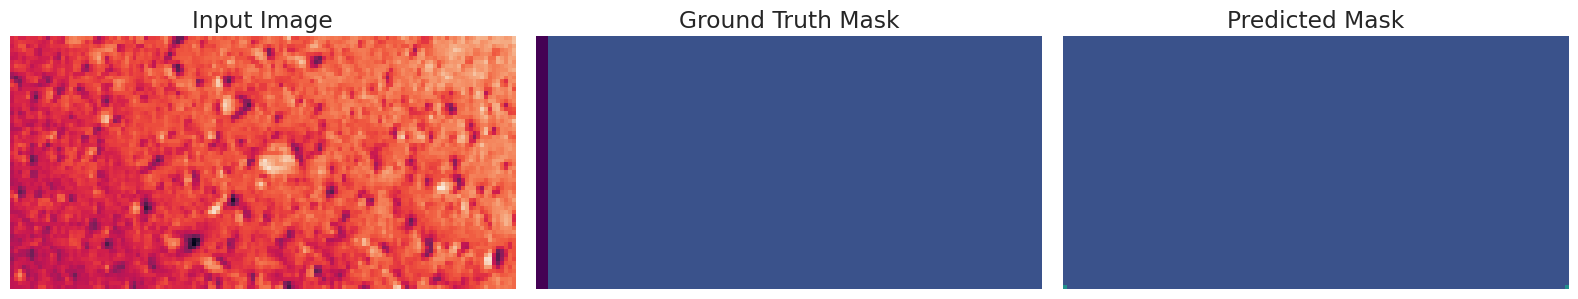

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.8089 - mean_iou: 0.3775 - sparse_categorical_crossentropy: 1.6363 - val_loss: 0.8361 - val_mean_iou: 0.4819 - val_sparse_categorical_crossentropy: 1.4971
Epoch 47/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.7726 - mean_iou: 0.3831 - sparse_categorical_crossentropy: 1.6263 - val_loss: 0.7795 - val_mean_iou: 0.5021 - val_sparse_categorical_crossentropy: 1.4804
Epoch 48/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.7772 - mean_iou: 0.3686 - sparse_categorical_crossentropy: 1.6365 - val_loss: 0.9029 - val_mean_iou: 0.4586 - val_sparse_categorical_crossentropy: 1.5174
Epoch 49/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.8162 - mean_iou: 0.3895 - sparse_categorical_crossentropy: 1.6603 - val_loss: 0.9006 - val_mean_iou: 0.4942 - val_sparse_categorical_crossentropy: 1.4738
Epoch 50/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.8402 - mean_iou: 0.3651 - sparse_categorical_crossentropy: 1.6559 - val_loss: 

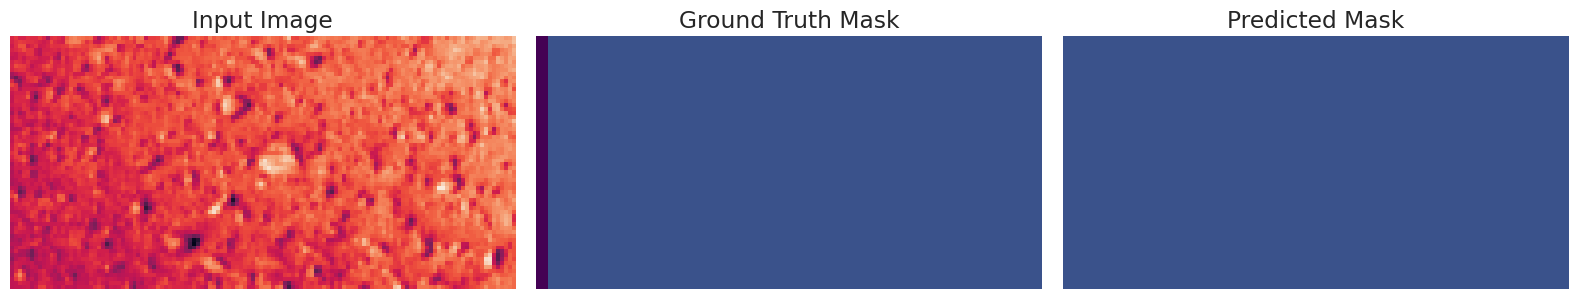

66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - loss: 0.9197 - mean_iou: 0.3629 - sparse_categorical_crossentropy: 1.7046 - val_loss: 0.8787 - val_mean_iou: 0.4731 - val_sparse_categorical_crossentropy: 1.4923
Epoch 52/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.7907 - mean_iou: 0.3747 - sparse_categorical_crossentropy: 1.6878 - val_loss: 1.0950 - val_mean_iou: 0.4858 - val_sparse_categorical_crossentropy: 1.5035
Epoch 53/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.9288 - mean_iou: 0.4541 - sparse_categorical_crossentropy: 1.6722 - val_loss: 1.1132 - val_mean_iou: 0.4917 - val_sparse_categorical_crossentropy: 1.5147
Epoch 54/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.7878 - mean_iou: 0.4765 - sparse_categorical_crossentropy: 1.7054 - val_loss: 0.8995 - val_mean_iou: 0.5102 - val_sparse_categorical_crossentropy: 1.4707
Epoch 55/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.7733 - mean_iou: 0.4881 - sparse_categorical_crossentropy: 1.6896 - val_loss: 

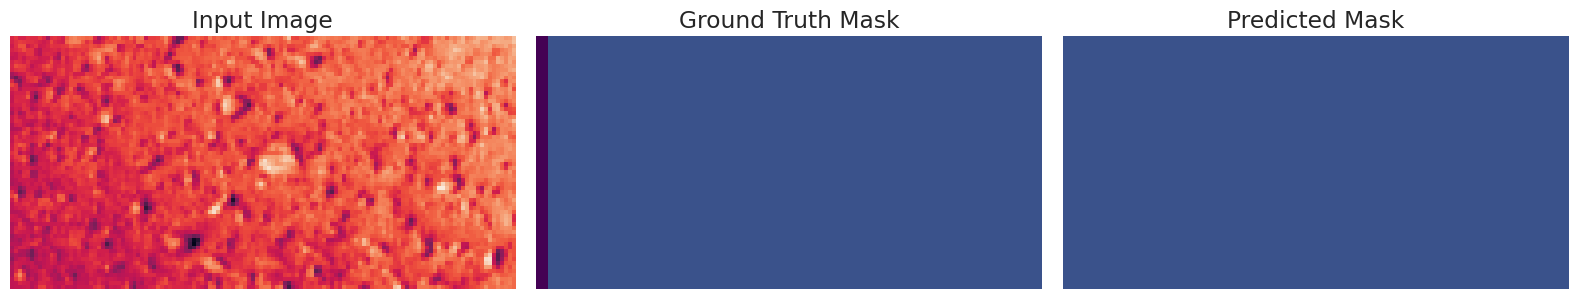

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 1.0291 - mean_iou: 0.3538 - sparse_categorical_crossentropy: 1.7233 - val_loss: 0.9186 - val_mean_iou: 0.3681 - val_sparse_categorical_crossentropy: 1.5813
Epoch 57/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.7702 - mean_iou: 0.3695 - sparse_categorical_crossentropy: 1.7045 - val_loss: 0.9993 - val_mean_iou: 0.4869 - val_sparse_categorical_crossentropy: 1.5578
Epoch 58/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.7041 - mean_iou: 0.4872 - sparse_categorical_crossentropy: 1.7107 - val_loss: 0.8725 - val_mean_iou: 0.5127 - val_sparse_categorical_crossentropy: 1.5145
Epoch 59/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.8535 - mean_iou: 0.3715 - sparse_categorical_crossentropy: 1.7111 - val_loss: 0.9439 - val_mean_iou: 0.4801 - val_sparse_categorical_crossentropy: 1.5327
Epoch 60/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.6924 - mean_iou: 0.4902 - sparse_categorical_crossentropy: 1.7109 - val_loss: 0

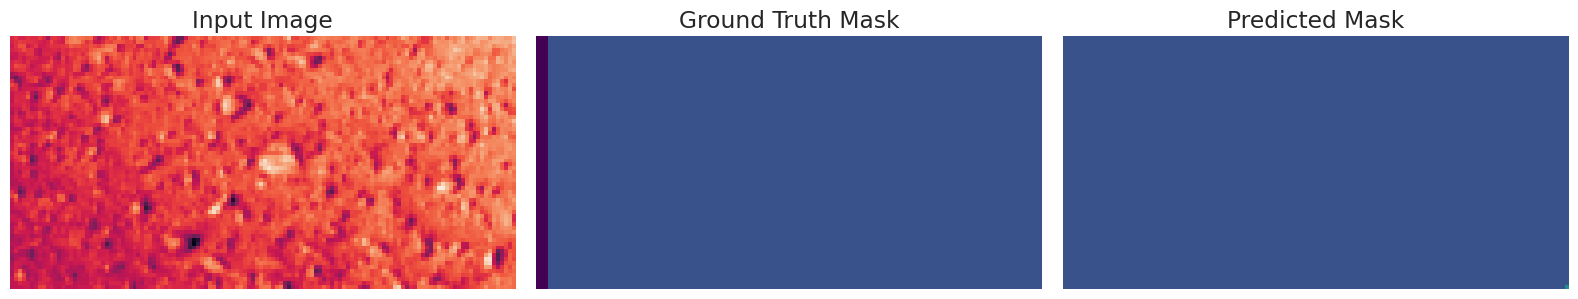

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 0.7180 - mean_iou: 0.4904 - sparse_categorical_crossentropy: 1.7365 - val_loss: 1.0137 - val_mean_iou: 0.4627 - val_sparse_categorical_crossentropy: 1.5894
Epoch 62/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 1.0740 - mean_iou: 0.3554 - sparse_categorical_crossentropy: 1.7353 - val_loss: 0.8196 - val_mean_iou: 0.4336 - val_sparse_categorical_crossentropy: 1.5845
Epoch 63/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.7455 - mean_iou: 0.4611 - sparse_categorical_crossentropy: 1.7566 - val_loss: 0.8591 - val_mean_iou: 0.5032 - val_sparse_categorical_crossentropy: 1.5762
Epoch 64/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.6868 - mean_iou: 0.3958 - sparse_categorical_crossentropy: 1.7468 - val_loss: 0.8427 - val_mean_iou: 0.5038 - val_sparse_categorical_crossentropy: 1.5543
Epoch 65/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.5833 - mean_iou: 0.5057 - sparse_categorical_crossentropy: 1.7493 - val_loss: 

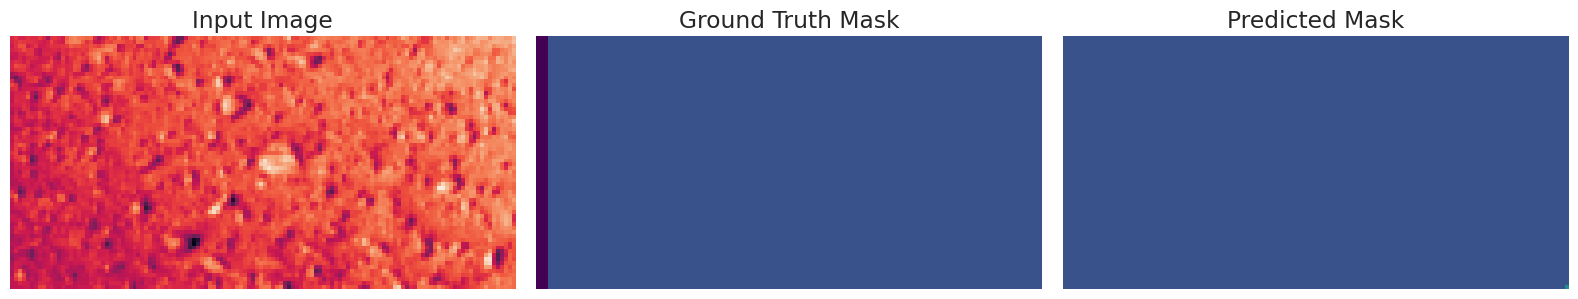

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.5670 - mean_iou: 0.5148 - sparse_categorical_crossentropy: 1.7770 - val_loss: 0.8724 - val_mean_iou: 0.5196 - val_sparse_categorical_crossentropy: 1.5624
Epoch 67/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.7774 - mean_iou: 0.4242 - sparse_categorical_crossentropy: 1.7790 - val_loss: 0.8987 - val_mean_iou: 0.4368 - val_sparse_categorical_crossentropy: 1.6109
Epoch 68/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.8459 - mean_iou: 0.4634 - sparse_categorical_crossentropy: 1.7713 - val_loss: 0.7409 - val_mean_iou: 0.5102 - val_sparse_categorical_crossentropy: 1.5721
Epoch 69/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.6609 - mean_iou: 0.4902 - sparse_categorical_crossentropy: 1.7822 - val_loss: 1.2850 - val_mean_iou: 0.5187 - val_sparse_categorical_crossentropy: 1.5493
Epoch 70/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.5563 - mean_iou: 0.5130 - sparse_categorical_crossentropy: 1.7701 - val_loss: 0

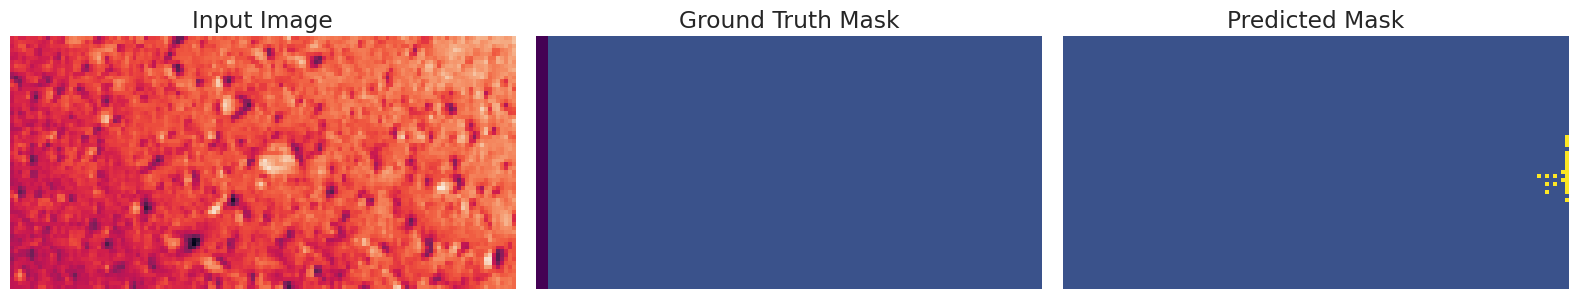

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.5952 - mean_iou: 0.5182 - sparse_categorical_crossentropy: 1.7711 - val_loss: 0.9142 - val_mean_iou: 0.5151 - val_sparse_categorical_crossentropy: 1.5499
Epoch 72/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.6570 - mean_iou: 0.5111 - sparse_categorical_crossentropy: 1.7845 - val_loss: 0.7908 - val_mean_iou: 0.5157 - val_sparse_categorical_crossentropy: 1.5454
Epoch 73/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.6067 - mean_iou: 0.5086 - sparse_categorical_crossentropy: 1.7865 - val_loss: 0.9014 - val_mean_iou: 0.5454 - val_sparse_categorical_crossentropy: 1.5635
Epoch 74/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.5466 - mean_iou: 0.5301 - sparse_categorical_crossentropy: 1.7891 - val_loss: 0.7417 - val_mean_iou: 0.5138 - val_sparse_categorical_crossentropy: 1.6192
Epoch 75/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.5775 - mean_iou: 0.5077 - sparse_categorical_crossentropy: 1.8196 - val_loss: 0

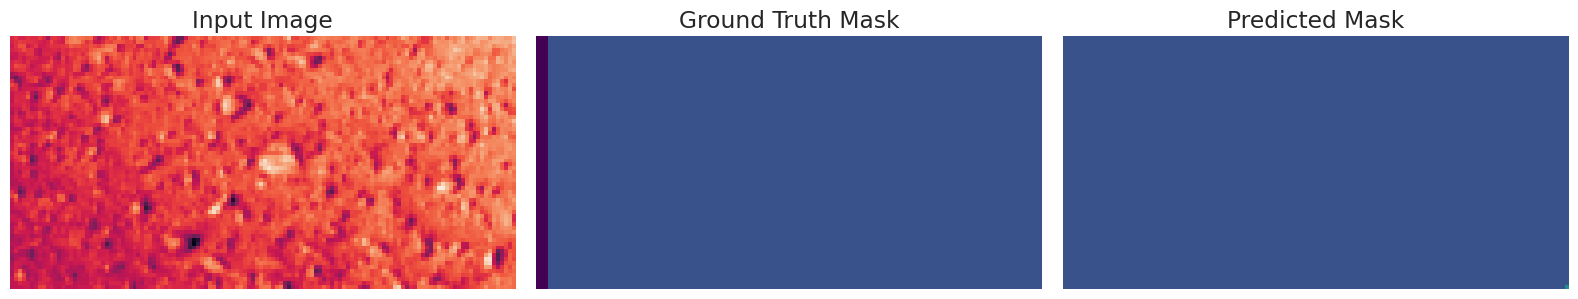

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.7183 - mean_iou: 0.5064 - sparse_categorical_crossentropy: 1.8003 - val_loss: 0.7990 - val_mean_iou: 0.5230 - val_sparse_categorical_crossentropy: 1.5739
Epoch 77/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.5475 - mean_iou: 0.5172 - sparse_categorical_crossentropy: 1.8106 - val_loss: 1.0277 - val_mean_iou: 0.4907 - val_sparse_categorical_crossentropy: 1.5934
Epoch 78/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.5778 - mean_iou: 0.4938 - sparse_categorical_crossentropy: 1.8379 - val_loss: 1.0043 - val_mean_iou: 0.5082 - val_sparse_categorical_crossentropy: 1.5836
Epoch 79/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.5530 - mean_iou: 0.5230 - sparse_categorical_crossentropy: 1.8394 - val_loss: 1.4014 - val_mean_iou: 0.5401 - val_sparse_categorical_crossentropy: 1.5579
Epoch 80/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.5446 - mean_iou: 0.5200 - sparse_categorical_crossentropy: 1.8386 - val_loss: 1

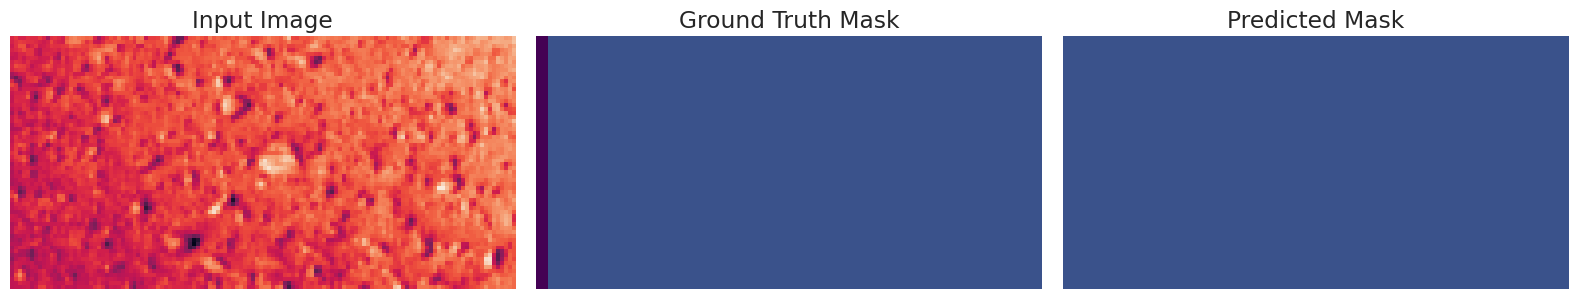

66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 0.5828 - mean_iou: 0.5056 - sparse_categorical_crossentropy: 1.8579 - val_loss: 0.9107 - val_mean_iou: 0.5186 - val_sparse_categorical_crossentropy: 1.6421
Epoch 82/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.6472 - mean_iou: 0.5007 - sparse_categorical_crossentropy: 1.8756 - val_loss: 0.7283 - val_mean_iou: 0.5060 - val_sparse_categorical_crossentropy: 1.6309
Epoch 83/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.8486 - mean_iou: 0.4308 - sparse_categorical_crossentropy: 1.8562 - val_loss: 1.0452 - val_mean_iou: 0.4917 - val_sparse_categorical_crossentropy: 1.6621
Epoch 84/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.6326 - mean_iou: 0.5006 - sparse_categorical_crossentropy: 1.8524 - val_loss: 0.9045 - val_mean_iou: 0.5201 - val_sparse_categorical_crossentropy: 1.5896
Epoch 85/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.5591 - mean_iou: 0.5234 - sparse_categorical_crossentropy: 1.9002 - val_loss:

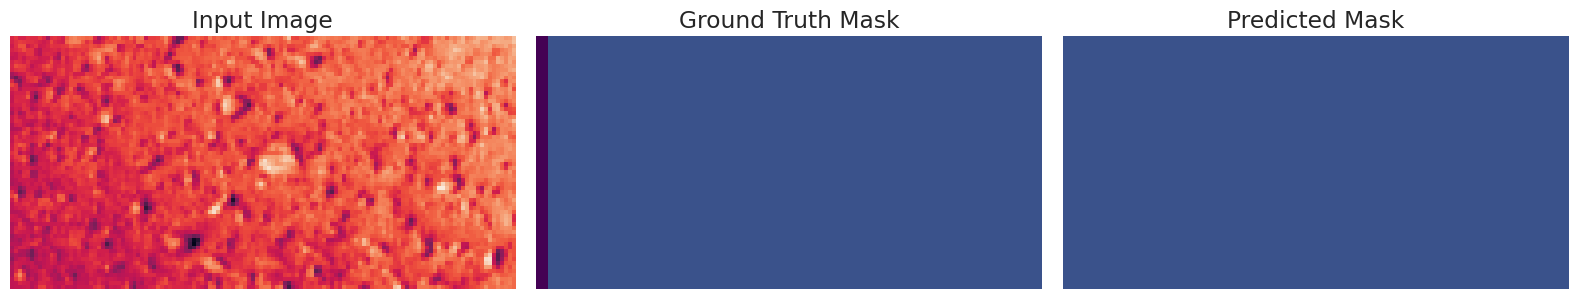

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 0.5116 - mean_iou: 0.5359 - sparse_categorical_crossentropy: 1.8761 - val_loss: 1.0738 - val_mean_iou: 0.5601 - val_sparse_categorical_crossentropy: 1.5799
Epoch 87/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.4763 - mean_iou: 0.5451 - sparse_categorical_crossentropy: 1.9138 - val_loss: 1.2069 - val_mean_iou: 0.5451 - val_sparse_categorical_crossentropy: 1.5719
Epoch 88/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.4640 - mean_iou: 0.5535 - sparse_categorical_crossentropy: 1.9016 - val_loss: 1.3886 - val_mean_iou: 0.5385 - val_sparse_categorical_crossentropy: 1.5807
Epoch 89/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.5188 - mean_iou: 0.5405 - sparse_categorical_crossentropy: 1.9256 - val_loss: 0.7766 - val_mean_iou: 0.5229 - val_sparse_categorical_crossentropy: 1.6323
Epoch 90/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.7085 - mean_iou: 0.4877 - sparse_categorical_crossentropy: 1.9396 - val_loss: 

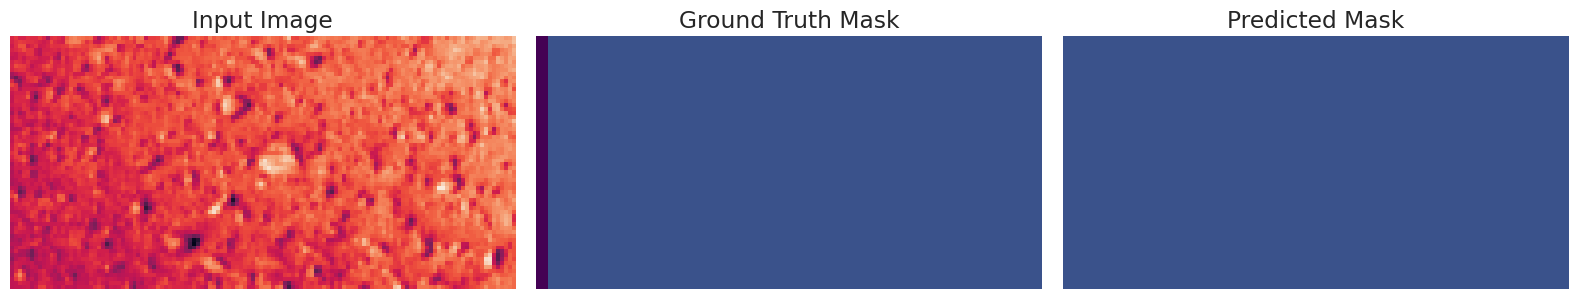

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.5699 - mean_iou: 0.5231 - sparse_categorical_crossentropy: 1.9585 - val_loss: 1.7529 - val_mean_iou: 0.3302 - val_sparse_categorical_crossentropy: 1.7113
Epoch 92/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.7644 - mean_iou: 0.3446 - sparse_categorical_crossentropy: 1.9384 - val_loss: 0.9026 - val_mean_iou: 0.4950 - val_sparse_categorical_crossentropy: 1.6811
Epoch 93/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.5329 - mean_iou: 0.5213 - sparse_categorical_crossentropy: 1.9529 - val_loss: 1.0129 - val_mean_iou: 0.5467 - val_sparse_categorical_crossentropy: 1.6430
Epoch 94/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.5086 - mean_iou: 0.5229 - sparse_categorical_crossentropy: 1.9355 - val_loss: 1.1593 - val_mean_iou: 0.5589 - val_sparse_categorical_crossentropy: 1.6270
Epoch 95/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.4969 - mean_iou: 0.5232 - sparse_categorical_crossentropy: 1.9771 - val_loss: 

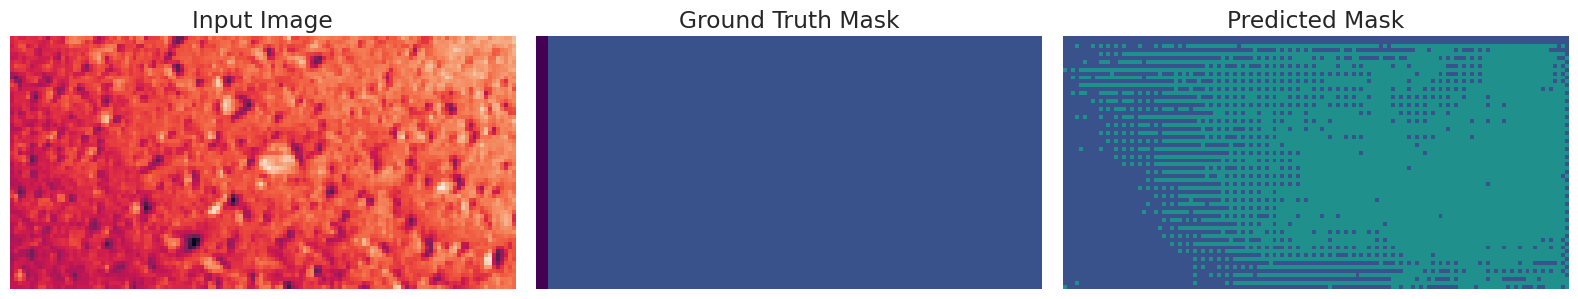

66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 0.9369 - mean_iou: 0.4336 - sparse_categorical_crossentropy: 1.9724 - val_loss: 1.7758 - val_mean_iou: 0.3730 - val_sparse_categorical_crossentropy: 1.8564
Epoch 97/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 1.2239 - mean_iou: 0.3856 - sparse_categorical_crossentropy: 1.9347 - val_loss: 1.1756 - val_mean_iou: 0.3354 - val_sparse_categorical_crossentropy: 1.7901
Epoch 98/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.7179 - mean_iou: 0.4837 - sparse_categorical_crossentropy: 1.9679 - val_loss: 0.9324 - val_mean_iou: 0.4943 - val_sparse_categorical_crossentropy: 1.6931
Epoch 99/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.5491 - mean_iou: 0.5255 - sparse_categorical_crossentropy: 1.9552 - val_loss: 0.8847 - val_mean_iou: 0.5498 - val_sparse_categorical_crossentropy: 1.6454
Epoch 100/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.5591 - mean_iou: 0.5337 - sparse_categorical_crossentropy: 1.9805 - val_loss: 

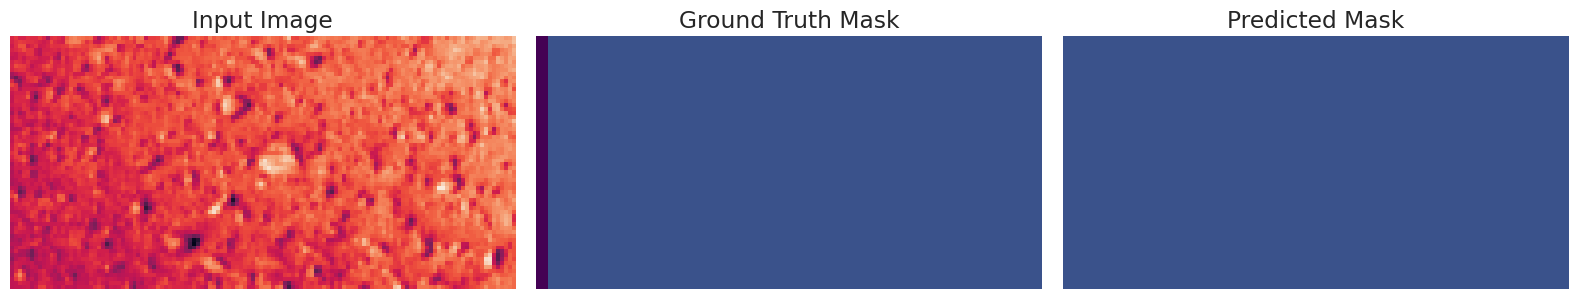

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.5264 - mean_iou: 0.5340 - sparse_categorical_crossentropy: 2.0130 - val_loss: 0.8313 - val_mean_iou: 0.5465 - val_sparse_categorical_crossentropy: 1.6982
Epoch 102/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.5496 - mean_iou: 0.5198 - sparse_categorical_crossentropy: 1.9977 - val_loss: 0.9099 - val_mean_iou: 0.5628 - val_sparse_categorical_crossentropy: 1.6569
Epoch 103/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.4809 - mean_iou: 0.5444 - sparse_categorical_crossentropy: 2.0142 - val_loss: 1.0254 - val_mean_iou: 0.5677 - val_sparse_categorical_crossentropy: 1.6660
Epoch 104/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.4574 - mean_iou: 0.5441 - sparse_categorical_crossentropy: 2.0510 - val_loss: 1.1279 - val_mean_iou: 0.5656 - val_sparse_categorical_crossentropy: 1.6546
Epoch 105/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.4173 - mean_iou: 0.5672 - sparse_categorical_crossentropy: 2.0416 - val_l

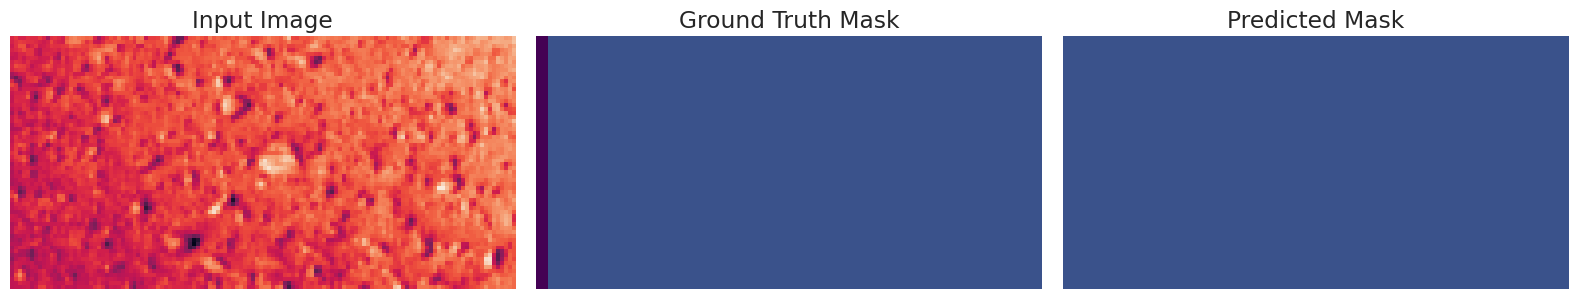

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 1.0179 - mean_iou: 0.4721 - sparse_categorical_crossentropy: 2.0533 - val_loss: 1.0756 - val_mean_iou: 0.3328 - val_sparse_categorical_crossentropy: 1.8801
Epoch 107/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.6902 - mean_iou: 0.4749 - sparse_categorical_crossentropy: 2.0353 - val_loss: 1.0543 - val_mean_iou: 0.5131 - val_sparse_categorical_crossentropy: 1.7053
Epoch 108/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.5969 - mean_iou: 0.5123 - sparse_categorical_crossentropy: 2.0525 - val_loss: 1.3937 - val_mean_iou: 0.5212 - val_sparse_categorical_crossentropy: 1.6899
Epoch 109/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.4811 - mean_iou: 0.5361 - sparse_categorical_crossentropy: 2.0874 - val_loss: 1.0208 - val_mean_iou: 0.5661 - val_sparse_categorical_crossentropy: 1.6821
Epoch 110/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.4515 - mean_iou: 0.5486 - sparse_categorical_crossentropy: 2.1202 - val_los

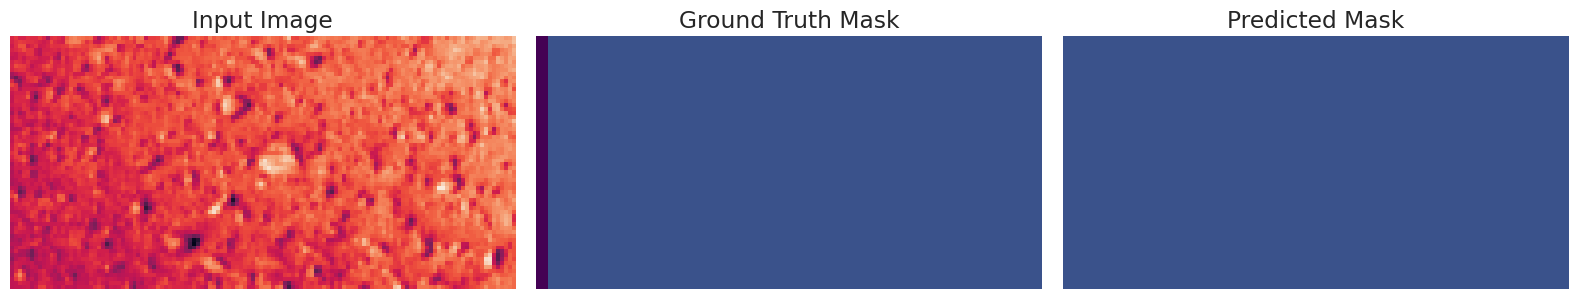

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.4436 - mean_iou: 0.5512 - sparse_categorical_crossentropy: 2.1179 - val_loss: 1.1210 - val_mean_iou: 0.5816 - val_sparse_categorical_crossentropy: 1.7052
Epoch 112/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.4586 - mean_iou: 0.5625 - sparse_categorical_crossentropy: 2.1339 - val_loss: 1.5463 - val_mean_iou: 0.5686 - val_sparse_categorical_crossentropy: 1.6848
Epoch 113/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.4086 - mean_iou: 0.5719 - sparse_categorical_crossentropy: 2.1367 - val_loss: 1.6048 - val_mean_iou: 0.5886 - val_sparse_categorical_crossentropy: 1.6903
Epoch 114/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.4059 - mean_iou: 0.5791 - sparse_categorical_crossentropy: 2.1578 - val_loss: 1.9568 - val_mean_iou: 0.5400 - val_sparse_categorical_crossentropy: 1.7247
Epoch 115/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.4060 - mean_iou: 0.5817 - sparse_categorical_crossentropy: 2.1749 - val_lo

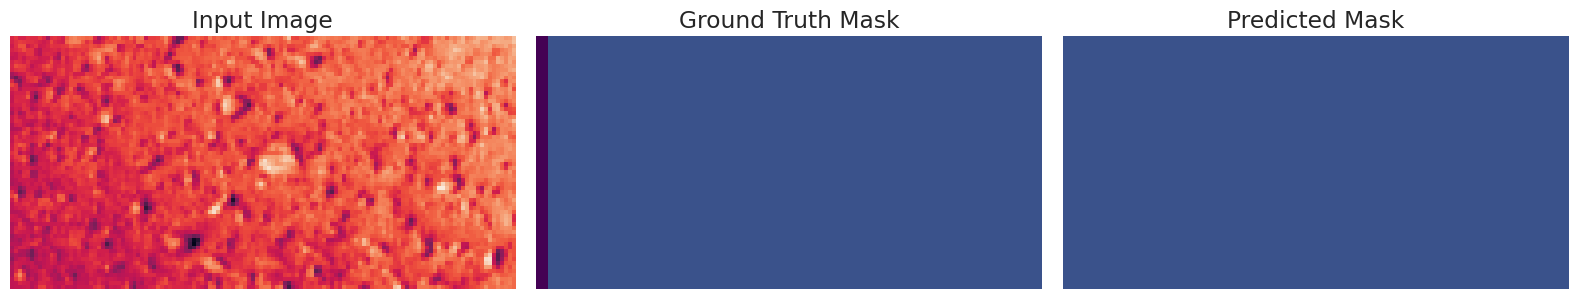

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - loss: 0.4166 - mean_iou: 0.5600 - sparse_categorical_crossentropy: 2.1724 - val_loss: 1.6928 - val_mean_iou: 0.5809 - val_sparse_categorical_crossentropy: 1.7094
Epoch 117/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.4295 - mean_iou: 0.5679 - sparse_categorical_crossentropy: 2.1879 - val_loss: 1.7043 - val_mean_iou: 0.5554 - val_sparse_categorical_crossentropy: 1.7440
Epoch 118/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.4030 - mean_iou: 0.5605 - sparse_categorical_crossentropy: 2.1953 - val_loss: 1.3883 - val_mean_iou: 0.5711 - val_sparse_categorical_crossentropy: 1.7088
Epoch 119/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.4268 - mean_iou: 0.5664 - sparse_categorical_crossentropy: 2.1957 - val_loss: 2.0220 - val_mean_iou: 0.5794 - val_sparse_categorical_crossentropy: 1.7019
Epoch 120/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.4015 - mean_iou: 0.5741 - sparse_categorical_crossentropy: 2.1934 - val_los

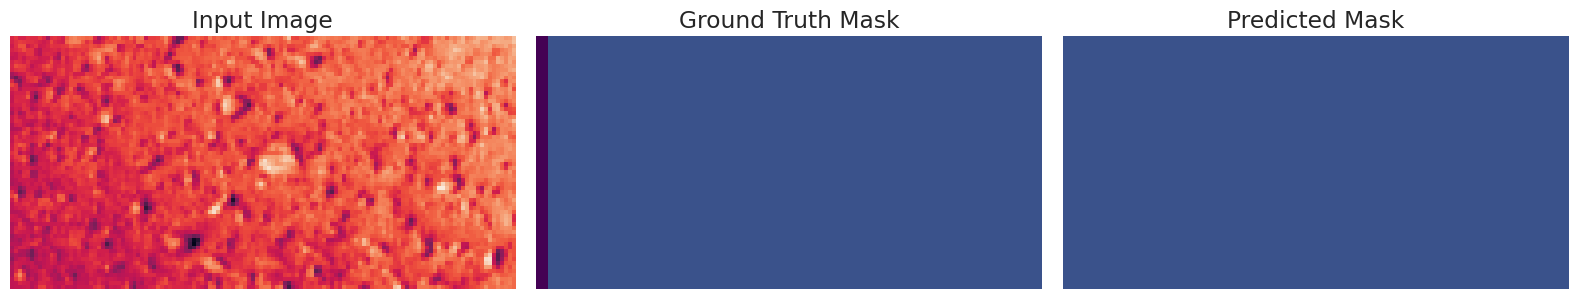

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.4529 - mean_iou: 0.5346 - sparse_categorical_crossentropy: 2.2025 - val_loss: 1.2809 - val_mean_iou: 0.5656 - val_sparse_categorical_crossentropy: 1.7027
Epoch 122/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.3832 - mean_iou: 0.5742 - sparse_categorical_crossentropy: 2.2192 - val_loss: 1.5666 - val_mean_iou: 0.5680 - val_sparse_categorical_crossentropy: 1.7293
Epoch 123/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.3690 - mean_iou: 0.5925 - sparse_categorical_crossentropy: 2.2183 - val_loss: 2.2324 - val_mean_iou: 0.5480 - val_sparse_categorical_crossentropy: 1.7631
Epoch 124/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.3664 - mean_iou: 0.5971 - sparse_categorical_crossentropy: 2.2187 - val_loss: 1.9143 - val_mean_iou: 0.5508 - val_sparse_categorical_crossentropy: 1.7325
Epoch 125/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 1.0076 - mean_iou: 0.4568 - sparse_categorical_crossentropy: 2.2319 - val_lo

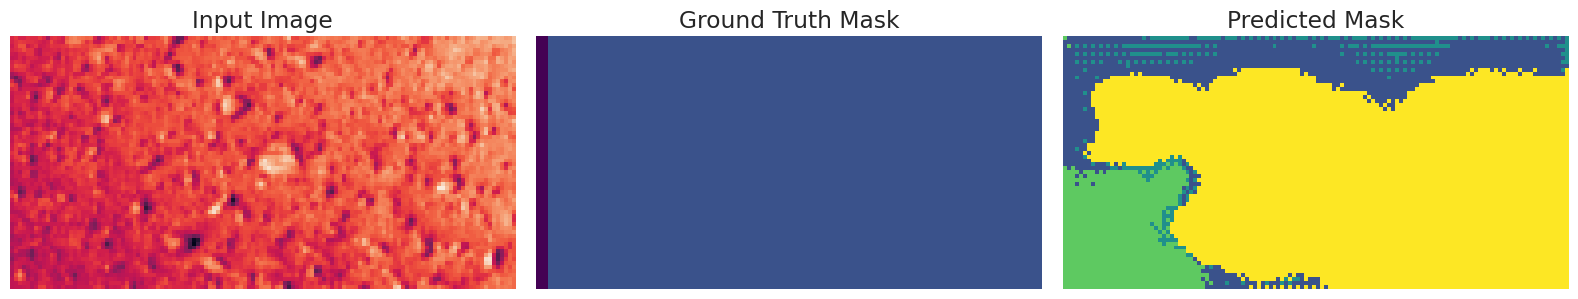

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 3.2758 - mean_iou: 0.1835 - sparse_categorical_crossentropy: 2.2025 - val_loss: 4.7494 - val_mean_iou: 0.1762 - val_sparse_categorical_crossentropy: 2.5700
Epoch 127/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 1.7907 - mean_iou: 0.2456 - sparse_categorical_crossentropy: 2.1757 - val_loss: 1.2989 - val_mean_iou: 0.2267 - val_sparse_categorical_crossentropy: 2.0330
Epoch 128/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 1.0225 - mean_iou: 0.2873 - sparse_categorical_crossentropy: 2.1606 - val_loss: 1.0479 - val_mean_iou: 0.3502 - val_sparse_categorical_crossentropy: 1.9607
Epoch 129/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.9108 - mean_iou: 0.3634 - sparse_categorical_crossentropy: 2.1923 - val_loss: 0.9479 - val_mean_iou: 0.3919 - val_sparse_categorical_crossentropy: 1.9379
Epoch 130/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.8903 - mean_iou: 0.3884 - sparse_categorical_crossentropy: 2.2107 - val_los

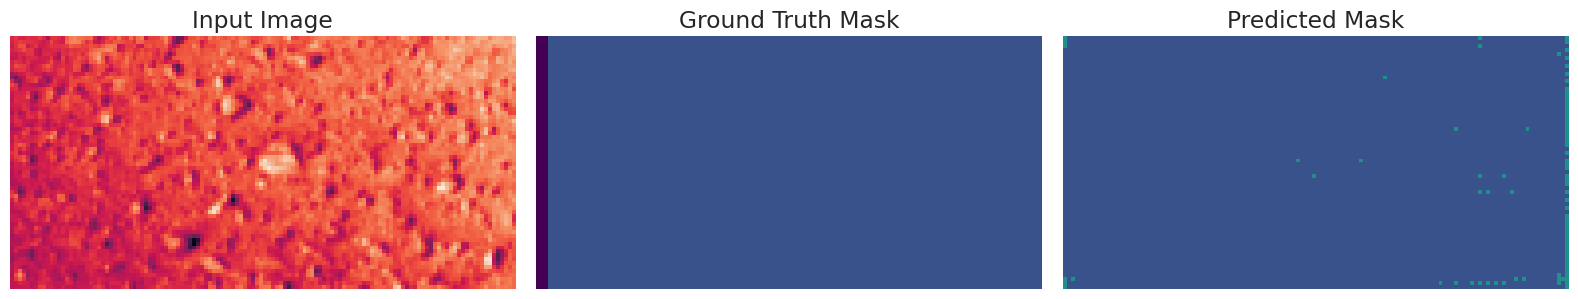

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.7490 - mean_iou: 0.4148 - sparse_categorical_crossentropy: 2.2383 - val_loss: 0.8703 - val_mean_iou: 0.4470 - val_sparse_categorical_crossentropy: 1.9208
Epoch 132/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.7535 - mean_iou: 0.4384 - sparse_categorical_crossentropy: 2.2402 - val_loss: 0.8209 - val_mean_iou: 0.4724 - val_sparse_categorical_crossentropy: 1.9049
Epoch 133/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.7460 - mean_iou: 0.3841 - sparse_categorical_crossentropy: 2.2650 - val_loss: 0.8134 - val_mean_iou: 0.4832 - val_sparse_categorical_crossentropy: 1.8906
Epoch 134/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.6468 - mean_iou: 0.3970 - sparse_categorical_crossentropy: 2.2692 - val_loss: 0.9075 - val_mean_iou: 0.5112 - val_sparse_categorical_crossentropy: 1.8720
Epoch 135/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.6050 - mean_iou: 0.4928 - sparse_categorical_crossentropy: 2.2763 - val_lo

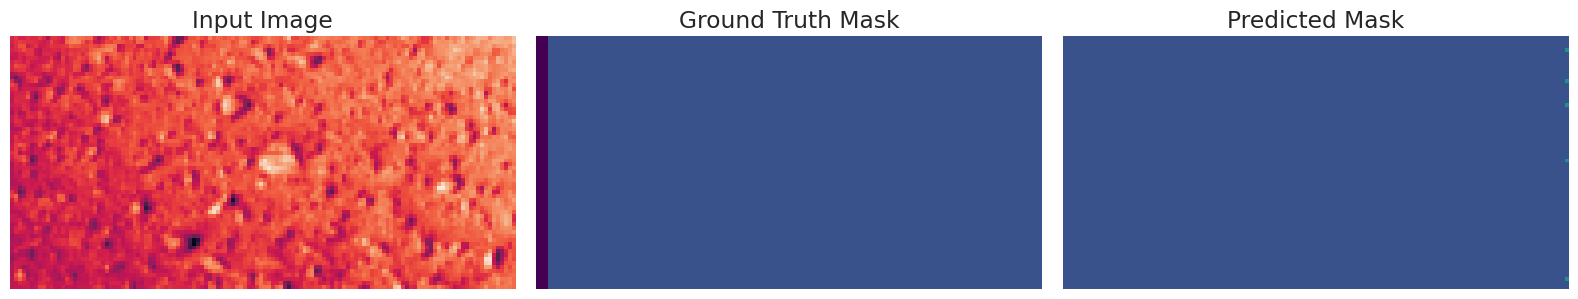

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.6070 - mean_iou: 0.5059 - sparse_categorical_crossentropy: 2.2921 - val_loss: 0.8923 - val_mean_iou: 0.5226 - val_sparse_categorical_crossentropy: 1.8766
Epoch 137/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.5482 - mean_iou: 0.5151 - sparse_categorical_crossentropy: 2.2980 - val_loss: 0.8311 - val_mean_iou: 0.5289 - val_sparse_categorical_crossentropy: 1.8721
Epoch 138/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.5716 - mean_iou: 0.5179 - sparse_categorical_crossentropy: 2.3113 - val_loss: 0.9932 - val_mean_iou: 0.5318 - val_sparse_categorical_crossentropy: 1.8600
Epoch 139/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.5183 - mean_iou: 0.5204 - sparse_categorical_crossentropy: 2.3049 - val_loss: 0.9693 - val_mean_iou: 0.5441 - val_sparse_categorical_crossentropy: 1.8644
Epoch 140/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.5728 - mean_iou: 0.5154 - sparse_categorical_crossentropy: 2.3200 - val_lo

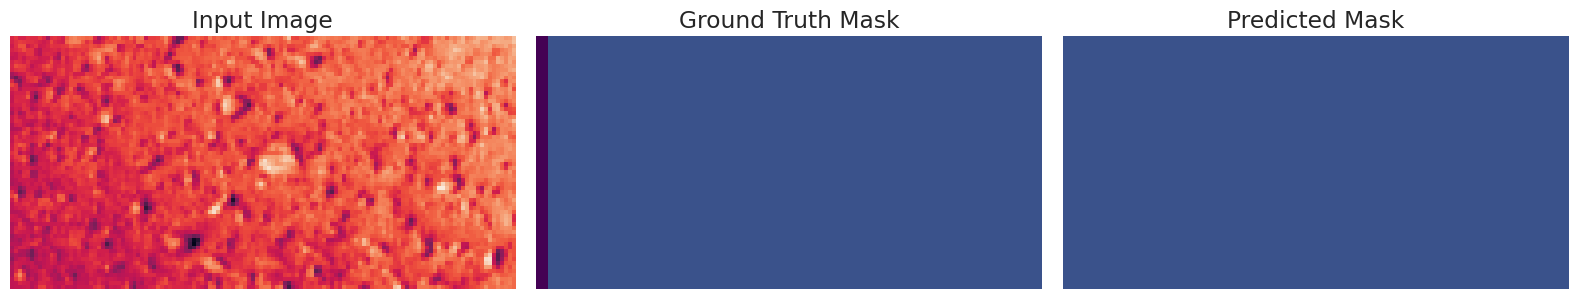

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.4857 - mean_iou: 0.5477 - sparse_categorical_crossentropy: 2.3294 - val_loss: 0.9521 - val_mean_iou: 0.5557 - val_sparse_categorical_crossentropy: 1.8322
Epoch 142/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.5200 - mean_iou: 0.5538 - sparse_categorical_crossentropy: 2.3178 - val_loss: 0.8919 - val_mean_iou: 0.5639 - val_sparse_categorical_crossentropy: 1.8406
Epoch 143/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.4620 - mean_iou: 0.5334 - sparse_categorical_crossentropy: 2.3411 - val_loss: 1.0834 - val_mean_iou: 0.5489 - val_sparse_categorical_crossentropy: 1.8303
Epoch 144/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.4504 - mean_iou: 0.5592 - sparse_categorical_crossentropy: 2.3627 - val_loss: 1.1378 - val_mean_iou: 0.5545 - val_sparse_categorical_crossentropy: 1.8298
Epoch 145/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - loss: 0.4271 - mean_iou: 0.5740 - sparse_categorical_crossentropy: 2.3755 - val_lo

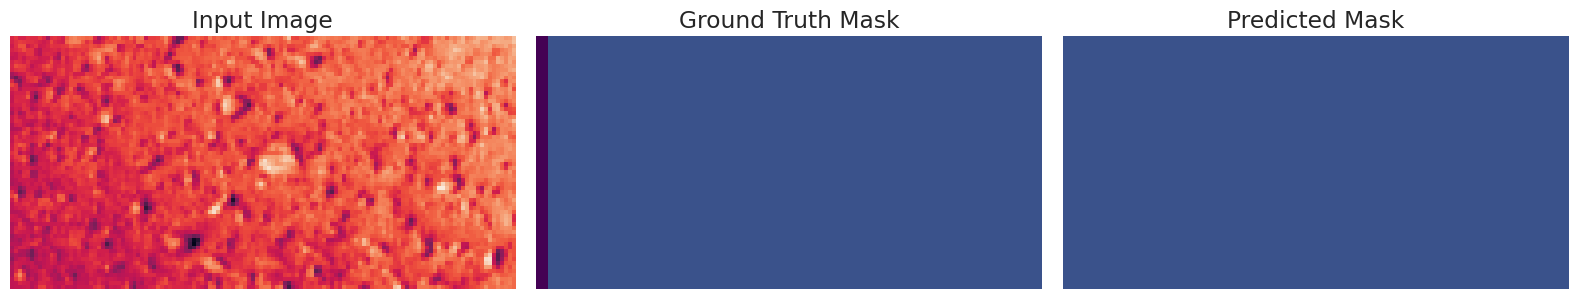

66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - loss: 0.4642 - mean_iou: 0.5508 - sparse_categorical_crossentropy: 2.3591 - val_loss: 0.9726 - val_mean_iou: 0.5492 - val_sparse_categorical_crossentropy: 1.8616
Epoch 147/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.4113 - mean_iou: 0.5748 - sparse_categorical_crossentropy: 2.3949 - val_loss: 1.2796 - val_mean_iou: 0.5708 - val_sparse_categorical_crossentropy: 1.8572
Epoch 148/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.4113 - mean_iou: 0.5698 - sparse_categorical_crossentropy: 2.4143 - val_loss: 1.1815 - val_mean_iou: 0.4625 - val_sparse_categorical_crossentropy: 1.9985
Epoch 149/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 1.8024 - mean_iou: 0.3981 - sparse_categorical_crossentropy: 2.3508 - val_loss: 1.5330 - val_mean_iou: 0.3416 - val_sparse_categorical_crossentropy: 2.2875
Epoch 150/150
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.9679 - mean_iou: 0.4092 - sparse_categorical_crossentropy: 2.2407 - val_lo

In [218]:
# Train the model
history = model.fit(
    train_dataset1,
    epochs=150,
    validation_data=val_dataset,
    callbacks=[early_stopping,viz_callback],
    verbose=1,
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

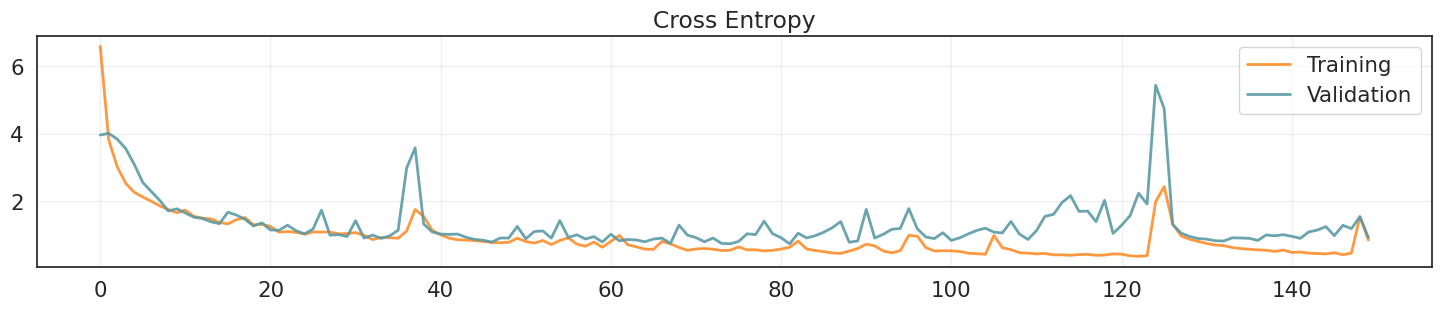

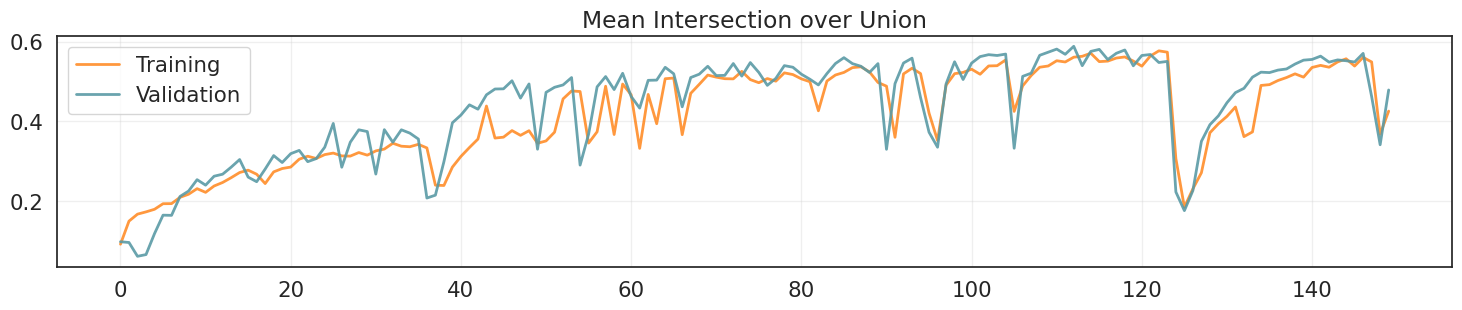

In [219]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Model Submission

In [225]:
model_filename="UNet_58.86.keras"

In [221]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [222]:
from tensorflow.keras.utils import get_custom_objects

# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None, ignore_class=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0. We want to exclude some classes we dont care
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

    @classmethod
    def from_config(cls, config):
        # Handle unexpected arguments like 'sparse_y_true' and 'sparse_y_pred'
        config.pop('sparse_y_true', None)
        config.pop('sparse_y_pred', None)
        config.pop('axis', None)

        # Ensure the 'ignore_class' argument is handled correctly
        config = {**config, 'labels_to_exclude': config.get('ignore_class', [0])}
        return cls(**config)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image_path, label_path, frequency=5):
        super().__init__()
        self.image_path = image_path
        self.label_path = label_path
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image_path, self.label_path)
            label = apply_category_mapping(label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = 5
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

get_custom_objects().update({'MeanIntersectionOverUnion': MeanIntersectionOverUnion})

In [226]:
tf.keras.config.enable_unsafe_deserialization()
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from UNet_58.86.keras


In [227]:
import pandas as pd

# Percorso del dataset
data_path = "mars_for_students.npz"

# Caricamento del dataset
data = np.load(data_path, allow_pickle=True)

# Estrarre i dati di testing
X_test = data["test_set"]

print(f"Dimensioni X_test: {X_test.shape}")

Dimensioni X_test: (10022, 64, 128)


In [228]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step
Predictions shape: (10022, 64, 128)


In [230]:
import pandas as pd


def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [231]:
# Create and save the CSV submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"{timestep_str}.csv"
submission_df = y_to_df(preds)

# Save to CSV (Kaggle environment will store the file in the kernel output directory)
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file saved as: {submission_filename}")

Submission file saved as: UNet_58.86.csv
